# Day 6: Introduction to LangGraph and State Management

## 🎯 Learning Objectives
- Understand what LangGraph is and why it's useful
- Learn about state graphs and nodes
- Build stateful workflows with LangGraph
- Implement conditional routing
- Persist state across sessions

## 📚 What is LangGraph?

**LangGraph** is a library for building stateful, multi-actor applications with LLMs. It extends LangChain with:

1. **Cycles and Feedback**: Unlike chains that are linear, graphs can have cycles
2. **Built-in Persistence**: Automatically save and restore state
3. **Human-in-the-Loop**: Pause execution for human input
4. **Streaming**: Stream tokens and intermediate steps
5. **Time Travel**: Replay and branch from any point

### When to Use LangGraph vs LangChain

| Use Case | LangChain | LangGraph |
|----------|-----------|----------|
| Simple Q&A | ✅ | ❌ |
| RAG queries | ✅ | ❌ |
| Multi-step workflows | ⚠️ | ✅ |
| Conditional logic | ⚠️ | ✅ |
| Human approval needed | ❌ | ✅ |
| Persistent state | ❌ | ✅ |
| Agent loops | ⚠️ | ✅ |

## 🔧 Setup

In [1]:
# Install required packages
import sys
!{sys.executable} -m pip install -q langgraph langchain-openai python-dotenv

In [7]:
import os
from dotenv import load_dotenv
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

# Load environment variables
load_dotenv()

# Initialize LLM
llm = ChatOpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    model="openai/gpt-3.5-turbo",
    temperature=0.7
)

print("✅ Setup complete!")

✅ Setup complete!


## 1️⃣ Basic Concepts: State and Nodes

### State
State is the shared data structure that flows through your graph. It's typically a TypedDict that defines what data your application tracks.

### Nodes
Nodes are functions that take the current state and return updates to it. Each node represents a step in your workflow.

In [8]:
# Define the state schema
class State(TypedDict):
    """The state of our simple chatbot."""
    messages: Annotated[list, add_messages]  # add_messages automatically appends new messages

# Define a node function
def chatbot(state: State):
    """A simple chatbot node that responds to the last message."""
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

print("State schema defined!")
print(f"State fields: {State.__annotations__.keys()}")

State schema defined!
State fields: dict_keys(['messages'])


## 2️⃣ Building Your First Graph

Let's create a simple chatbot graph with just one node.

In [9]:
# Create a new graph
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot", chatbot)

# Set the entry point (where the graph starts)
graph_builder.set_entry_point("chatbot")

# Set the finish point (where the graph ends)
graph_builder.set_finish_point("chatbot")

# Compile the graph
graph = graph_builder.compile()

print("✅ Graph compiled!")

✅ Graph compiled!


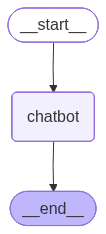

In [10]:
# Visualize the graph (optional - requires graphviz)
try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START -> chatbot -> END")

In [11]:
# Run the graph!
def run_chatbot(user_message: str):
    """Run the chatbot with a user message."""
    result = graph.invoke({
        "messages": [HumanMessage(content=user_message)]
    })
    return result["messages"][-1].content

# Test it
response = run_chatbot("Hello! What is LangGraph?")
print(f"Bot: {response}")

Bot: LangGraph is a natural language processing tool that uses graph-based techniques to analyze and generate text. It can be used for tasks such as text summarization, sentiment analysis, and entity recognition. LangGraph leverages the relationships between words and phrases in a text to extract meaningful insights and generate human-like responses.


## 3️⃣ Multi-Step Workflow with Multiple Nodes

Let's build a more interesting graph with multiple steps:
1. **Analyze** the user's question
2. **Generate** a response based on the analysis
3. **Format** the final output

In [12]:
# Define a more complex state
class WorkflowState(TypedDict):
    user_input: str
    analysis: str
    response: str
    final_output: str

# Node 1: Analyze the input
def analyze_input(state: WorkflowState):
    """Analyze the user's input to determine intent and complexity."""
    prompt = f"""Analyze this user input and provide a brief analysis:
    - What is the user asking for?
    - What complexity level? (simple/medium/complex)
    - What tone should the response have? (casual/professional/technical)
    
    User input: {state['user_input']}
    
    Provide a brief analysis (2-3 sentences)."""
    
    analysis = llm.invoke([HumanMessage(content=prompt)])
    return {"analysis": analysis.content}

# Node 2: Generate response
def generate_response(state: WorkflowState):
    """Generate a response based on the analysis."""
    prompt = f"""Based on this analysis, generate an appropriate response:
    
    Analysis: {state['analysis']}
    Original question: {state['user_input']}
    
    Generate a helpful response."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"response": response.content}

# Node 3: Format output
def format_output(state: WorkflowState):
    """Format the final output with some styling."""
    final = f"""╔═══════════════════════════════════════╗
║           ASSISTANT RESPONSE           ║
╚═══════════════════════════════════════╝

{state['response']}

---
[Analysis: {state['analysis'][:50]}...]
"""
    return {"final_output": final}

print("✅ Workflow nodes defined!")

✅ Workflow nodes defined!


In [13]:
# Build the multi-step graph
workflow_builder = StateGraph(WorkflowState)

# Add all nodes
workflow_builder.add_node("analyze", analyze_input)
workflow_builder.add_node("generate", generate_response)
workflow_builder.add_node("format", format_output)

# Define the flow: analyze -> generate -> format -> END
workflow_builder.set_entry_point("analyze")
workflow_builder.add_edge("analyze", "generate")
workflow_builder.add_edge("generate", "format")
workflow_builder.add_edge("format", END)

# Compile
workflow = workflow_builder.compile()

print("✅ Multi-step workflow compiled!")

✅ Multi-step workflow compiled!


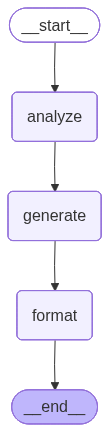

In [14]:
# Visualize the workflow
try:
    from IPython.display import Image, display
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START -> analyze -> generate -> format -> END")

In [15]:
# Run the workflow
result = workflow.invoke({
    "user_input": "What are the key differences between LangChain and LangGraph?"
})

print(result["final_output"])

╔═══════════════════════════════════════╗
║           ASSISTANT RESPONSE           ║
╚═══════════════════════════════════════╝

LangChain and LangGraph are both technologies used in the field of natural language processing, but they serve different purposes and have distinct features. 

LangChain is a blockchain-based platform that focuses on providing secure and transparent language data storage and processing. It leverages blockchain technology to ensure data integrity and confidentiality in language-related applications.

On the other hand, LangGraph is a graph-based data modeling tool that helps in visualizing and analyzing language data in a structured way. It allows users to create and manipulate graph structures to represent relationships between linguistic elements.

In summary, LangChain emphasizes security and transparency in language data management, while LangGraph is more focused on visualizing and analyzing language data through graph structures.

---
[Analysis: The user 

## 4️⃣ Conditional Routing

One of LangGraph's superpowers is **conditional edges** - routing to different nodes based on conditions.

Let's build a customer service bot that routes to different handlers based on the query type.

In [16]:
class CustomerServiceState(TypedDict):
    query: str
    query_type: str  # "technical", "billing", "general"
    response: str

# Classifier node
def classify_query(state: CustomerServiceState):
    """Classify the customer query into categories."""
    prompt = f"""Classify this customer query into ONE category:
    - technical: Technical issues, bugs, how-to questions
    - billing: Payment, subscription, refund questions
    - general: General inquiries, feedback, other
    
    Query: {state['query']}
    
    Respond with ONLY the category name (technical/billing/general)."""
    
    classification = llm.invoke([HumanMessage(content=prompt)])
    query_type = classification.content.strip().lower()
    return {"query_type": query_type}

# Handler nodes
def handle_technical(state: CustomerServiceState):
    """Handle technical queries."""
    prompt = f"""You are a technical support specialist. Help with this query:
    {state['query']}
    
    Provide a technical, detailed response."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"response": f"[TECHNICAL SUPPORT]\n{response.content}"}

def handle_billing(state: CustomerServiceState):
    """Handle billing queries."""
    prompt = f"""You are a billing specialist. Help with this query:
    {state['query']}
    
    Provide a clear, policy-focused response."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"response": f"[BILLING DEPARTMENT]\n{response.content}"}

def handle_general(state: CustomerServiceState):
    """Handle general queries."""
    prompt = f"""You are a friendly customer service representative. Help with this query:
    {state['query']}
    
    Provide a warm, helpful response."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"response": f"[CUSTOMER SERVICE]\n{response.content}"}

# Routing function
def route_query(state: CustomerServiceState):
    """Decide which handler to use based on query type."""
    query_type = state["query_type"]
    
    if "technical" in query_type:
        return "technical"
    elif "billing" in query_type:
        return "billing"
    else:
        return "general"

print("✅ Customer service nodes defined!")

✅ Customer service nodes defined!


In [17]:
# Build the routing graph
cs_builder = StateGraph(CustomerServiceState)

# Add nodes
cs_builder.add_node("classify", classify_query)
cs_builder.add_node("technical", handle_technical)
cs_builder.add_node("billing", handle_billing)
cs_builder.add_node("general", handle_general)

# Set entry point
cs_builder.set_entry_point("classify")

# Add conditional edges from classify to handlers
cs_builder.add_conditional_edges(
    "classify",
    route_query,
    {
        "technical": "technical",
        "billing": "billing",
        "general": "general"
    }
)

# All handlers lead to END
cs_builder.add_edge("technical", END)
cs_builder.add_edge("billing", END)
cs_builder.add_edge("general", END)

# Compile
cs_graph = cs_builder.compile()

print("✅ Customer service graph compiled!")

✅ Customer service graph compiled!


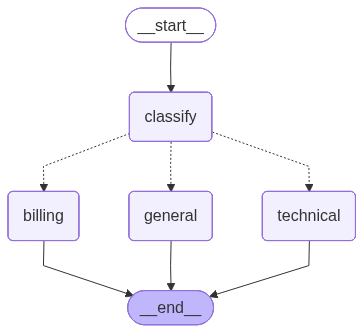

In [18]:
# Visualize the routing graph
try:
    from IPython.display import Image, display
    display(Image(cs_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START -> classify -> [technical/billing/general] -> END")

In [19]:
# Test with different query types
test_queries = [
    "My app keeps crashing when I try to export data. How do I fix this?",
    "I was charged twice this month. Can I get a refund?",
    "What are your business hours?"
]

for query in test_queries:
    print(f"\n{'='*60}")
    print(f"QUERY: {query}")
    print(f"{'='*60}")
    
    result = cs_graph.invoke({"query": query})
    print(f"\nType: {result['query_type']}")
    print(f"\n{result['response']}")


QUERY: My app keeps crashing when I try to export data. How do I fix this?

Type: technical

[TECHNICAL SUPPORT]
There are a few possible reasons why your app may be crashing when you try to export data. Here are some troubleshooting steps you can take to fix this issue:

1. Check for software updates: Make sure that your app and the operating system on your device are up to date. Sometimes, bugs in older versions of software can cause crashes when performing certain actions like exporting data.

2. Check for sufficient storage space: If your device is running low on storage space, it may struggle to export data properly. Try freeing up some space by deleting unnecessary files or apps.

3. Close other apps: Running multiple apps at the same time can sometimes cause conflicts that lead to crashes. Try closing all other apps before attempting to export data.

4. Clear app cache: Cached data can sometimes cause issues with app functionality. Try clearing the cache for the app you're expe

## 5️⃣ State Persistence with Checkpointers

LangGraph can automatically save state at each step, allowing you to:
- Resume from interruptions
- Time travel (go back to previous states)
- Implement human-in-the-loop workflows

Let's build a chatbot with memory that persists across sessions.

In [20]:
from langgraph.checkpoint.memory import MemorySaver

# Create a checkpointer (in-memory for now)
memory = MemorySaver()

# Define state with conversation history
class ChatState(TypedDict):
    messages: Annotated[list, add_messages]
    user_name: str
    conversation_count: int

def stateful_chatbot(state: ChatState):
    """A chatbot that remembers context."""
    # Get user name from state
    user_name = state.get("user_name", "there")
    count = state.get("conversation_count", 0) + 1
    
    # Add system context
    messages = [
        SystemMessage(content=f"You are chatting with {user_name}. This is message #{count} in your conversation. Be friendly and refer to previous messages when relevant.")
    ] + state["messages"]
    
    response = llm.invoke(messages)
    
    return {
        "messages": [response],
        "conversation_count": count
    }

print("✅ Stateful chatbot defined!")

✅ Stateful chatbot defined!


In [21]:
# Build graph with checkpointing
chat_builder = StateGraph(ChatState)
chat_builder.add_node("chatbot", stateful_chatbot)
chat_builder.set_entry_point("chatbot")
chat_builder.set_finish_point("chatbot")

# Compile with checkpointer
persistent_chat = chat_builder.compile(checkpointer=memory)

print("✅ Persistent chatbot compiled!")

✅ Persistent chatbot compiled!


In [22]:
# Test persistence with a conversation thread
config = {"configurable": {"thread_id": "user_123"}}

# Conversation 1
print("Message 1:")
result1 = persistent_chat.invoke(
    {
        "messages": [HumanMessage(content="Hi! My name is Alex.")],
        "user_name": "Alex",
        "conversation_count": 0
    },
    config=config
)
print(result1["messages"][-1].content)
print(f"Count: {result1['conversation_count']}\n")

# Conversation 2 (remembers previous message)
print("Message 2:")
result2 = persistent_chat.invoke(
    {
        "messages": [HumanMessage(content="What's my name?")]
    },
    config=config
)
print(result2["messages"][-1].content)
print(f"Count: {result2['conversation_count']}\n")

# Conversation 3
print("Message 3:")
result3 = persistent_chat.invoke(
    {
        "messages": [HumanMessage(content="I'm learning LangGraph. Can you help me understand state management?")]
    },
    config=config
)
print(result3["messages"][-1].content)
print(f"Count: {result3['conversation_count']}")

Message 1:
Hi Alex! Nice to meet you. How can I assist you today?
Count: 1

Message 2:
Your name is Alex! How can I assist you, Alex?
Count: 2

Message 3:
Of course, Alex! In LangGraph, state management is crucial for keeping track of the current state of your application and updating it as needed. This is commonly achieved through variables or objects that hold the state data and functions that can update the state.

State management helps ensure that your application stays in sync and behaves as expected. Do you have any specific questions or concepts you'd like to explore further regarding state management in LangGraph?
Count: 3


## 6️⃣ Streaming Outputs

LangGraph supports streaming both:
1. **Tokens**: Stream LLM response tokens as they're generated
2. **Updates**: Stream state updates as nodes complete

In [23]:
# Stream node updates
print("Streaming workflow execution:\n")

for event in workflow.stream({
    "user_input": "Explain LangGraph state management in simple terms."
}):
    for node_name, node_output in event.items():
        print(f"\n📍 Node '{node_name}' completed:")
        print(f"   Output keys: {list(node_output.keys())}")
        if node_name == "format":
            print(f"\n{node_output['final_output']}")

Streaming workflow execution:


📍 Node 'analyze' completed:
   Output keys: ['analysis']

📍 Node 'generate' completed:
   Output keys: ['response']

📍 Node 'format' completed:
   Output keys: ['final_output']

╔═══════════════════════════════════════╗
║           ASSISTANT RESPONSE           ║
╚═══════════════════════════════════════╝

LangGraph state management refers to the process of managing the state of components in LangGraph, a programming language. In simpler terms, it involves keeping track of the data and status of different elements within a program to ensure they are updated and interact correctly with each other. 

For example, if you have a button in your LangGraph program that changes color when clicked, the state management system would track the current color of the button and update it accordingly when the button is clicked. This helps in creating dynamic and interactive user interfaces.

I hope this explanation helps clarify the concept of LangGraph state management 

## 7️⃣ Building a Research Assistant with LangGraph

Let's combine everything we've learned to build a research assistant that:
1. Takes a research question
2. Breaks it into sub-questions
3. Answers each sub-question
4. Synthesizes a final answer

In [24]:
class ResearchState(TypedDict):
    question: str
    sub_questions: list[str]
    answers: dict[str, str]
    final_answer: str
    current_sub_q_index: int

def break_down_question(state: ResearchState):
    """Break down the main question into 3 sub-questions."""
    prompt = f"""Break down this research question into exactly 3 simpler sub-questions:
    
    Question: {state['question']}
    
    Return ONLY the 3 sub-questions, one per line, numbered 1-3."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    sub_questions = [line.strip() for line in response.content.split('\n') if line.strip() and any(c.isdigit() for c in line[:3])]
    # Clean up the numbering
    sub_questions = [q.split('.', 1)[-1].strip() if '.' in q[:4] else q for q in sub_questions]
    
    return {
        "sub_questions": sub_questions[:3],  # Ensure only 3
        "answers": {},
        "current_sub_q_index": 0
    }

def answer_sub_question(state: ResearchState):
    """Answer one sub-question."""
    idx = state["current_sub_q_index"]
    sub_q = state["sub_questions"][idx]
    
    prompt = f"""Answer this question concisely (2-3 sentences):
    {sub_q}
    
    Context: This is part of answering the larger question: {state['question']}"""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    
    # Update answers
    answers = state.get("answers", {}).copy()
    answers[sub_q] = response.content
    
    return {
        "answers": answers,
        "current_sub_q_index": idx + 1
    }

def should_continue(state: ResearchState):
    """Decide if we should answer more sub-questions."""
    if state["current_sub_q_index"] < len(state["sub_questions"]):
        return "continue"
    return "synthesize"

def synthesize_answer(state: ResearchState):
    """Synthesize all sub-answers into a final comprehensive answer."""
    sub_answers_text = "\n\n".join([
        f"Q: {q}\nA: {a}" 
        for q, a in state["answers"].items()
    ])
    
    prompt = f"""Based on these sub-question answers, provide a comprehensive answer to the main question:
    
    Main Question: {state['question']}
    
    Sub-questions and answers:
    {sub_answers_text}
    
    Synthesize a clear, comprehensive final answer (4-6 sentences)."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"final_answer": response.content}

print("✅ Research assistant nodes defined!")

✅ Research assistant nodes defined!


In [25]:
# Build the research graph
research_builder = StateGraph(ResearchState)

# Add nodes
research_builder.add_node("break_down", break_down_question)
research_builder.add_node("answer", answer_sub_question)
research_builder.add_node("synthesize", synthesize_answer)

# Set entry point
research_builder.set_entry_point("break_down")

# Define the flow
research_builder.add_edge("break_down", "answer")

# Conditional edge: keep answering or move to synthesis
research_builder.add_conditional_edges(
    "answer",
    should_continue,
    {
        "continue": "answer",  # Loop back to answer next question
        "synthesize": "synthesize"
    }
)

research_builder.add_edge("synthesize", END)

# Compile
research_graph = research_builder.compile()

print("✅ Research graph compiled!")

✅ Research graph compiled!


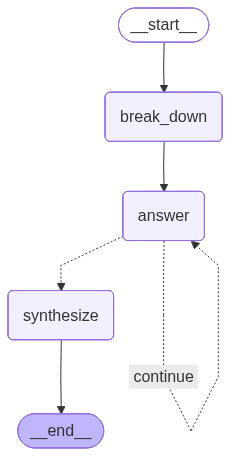

In [26]:
# Visualize the research graph
try:
    from IPython.display import Image, display
    display(Image(research_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START -> break_down -> answer -> [loop or synthesize] -> END")

In [28]:
# Run the research assistant
research_question = "How do indexes work in Postgres?"

print(f"🔍 Research Question: {research_question}\n")
print("=" * 80)

result = research_graph.invoke({"question": research_question})

print("\n📋 SUB-QUESTIONS AND ANSWERS:\n")
for i, (q, a) in enumerate(result["answers"].items(), 1):
    print(f"{i}. {q}")
    print(f"   → {a}\n")

print("\n" + "=" * 80)
print("\n🎯 FINAL SYNTHESIZED ANSWER:\n")
print(result["final_answer"])

🔍 Research Question: How do indexes work in Postgres?


📋 SUB-QUESTIONS AND ANSWERS:

1. What is the purpose of indexes in Postgres?
   → Indexes in Postgres are used to improve the performance of queries by allowing the database to quickly locate rows that match specified criteria. They work by creating a separate data structure that organizes the indexed columns in a way that reduces the amount of data that needs to be scanned during query execution.

2. How are indexes created in Postgres?
   → Indexes in Postgres are created using the CREATE INDEX statement, which specifies the table and column(s) to be indexed. Postgres then uses a data structure called B-tree to organize the index entries for efficient data retrieval.

3. How do indexes improve the performance of queries in Postgres?
   → Indexes in Postgres improve query performance by allowing the database to quickly locate specific rows in a table without having to scan the entire table. This is achieved by creating a data str

## 🎓 Key Takeaways

1. **State is Central**: Everything in LangGraph flows through state
2. **Nodes are Functions**: Each node transforms state
3. **Edges Define Flow**: Use regular edges for linear flow, conditional edges for branching
4. **Checkpointers Enable Persistence**: Save state automatically for resumable workflows
5. **Streaming Provides Visibility**: See what's happening as it happens
6. **Loops are Natural**: Use conditional edges to create cycles

## 📝 Exercises

1. **Modify the research assistant** to handle 4-5 sub-questions instead of 3
2. **Add error handling** to one of the graphs (e.g., retry on failure)
3. **Build a content moderation workflow** that:
   - Checks if content is safe
   - If unsafe, rewrites it
   - If safe, passes it through
4. **Create a graph with cycles** (e.g., a review loop that can go back to edit)

## 🚀 Next Steps

Tomorrow (Day 7), we'll learn about:
- **Human-in-the-loop** patterns
- **Interrupts** for approval workflows
- **Breakpoints** for debugging
- Building **approval workflows**

## 💡 Bonus: Comparing State Management Patterns

Let's compare different ways to manage state in LangGraph:

In [ ]:
# Pattern 1: Simple replacement (default)
class SimpleState(TypedDict):
    counter: int

# Pattern 2: Append to list (using add_messages)
class AppendState(TypedDict):
    items: Annotated[list, lambda x, y: x + y]  # Custom reducer

# Pattern 3: Merge dictionaries
from operator import add

def merge_dicts(left: dict, right: dict) -> dict:
    """Merge two dictionaries."""
    return {**left, **right}

class MergeState(TypedDict):
    data: Annotated[dict, merge_dicts]

print("State patterns defined!")
print("\n1. Simple: Just replace the value")
print("2. Append: Add to existing list")
print("3. Merge: Combine dictionaries")

## 🔗 Resources

- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [LangGraph Concepts](https://langchain-ai.github.io/langgraph/concepts/)
- [LangGraph How-to Guides](https://langchain-ai.github.io/langgraph/how-tos/)
- [State Management in LangGraph](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)

---

**Day 6 Complete! 🎉**

You now understand:
- ✅ LangGraph basics and state management
- ✅ Building multi-node workflows
- ✅ Conditional routing
- ✅ State persistence with checkpointers
- ✅ Streaming outputs
- ✅ Building complex graphs with loops